In [13]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Lambda, Activation
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import matthews_corrcoef, confusion_matrix

# ================== Configuration ==================
AMINO_ACIDS = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
SPACER_IDX = 20  # 21st unit for spacer/padding
LABEL_MAP = {'h':0, 'e':1, '_':2}  # 3-class mapping as per paper

# ================== Data Loading & Preprocessing ==================
def parse_data(file_path):
    sequences = []
    current_seq = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#') or not line:
                continue
            if line in ('<>', '<end>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = []
                continue
            parts = line.split()
            if len(parts) == 2 and parts[1].lower() in LABEL_MAP:
                current_seq.append((parts[0].upper(), parts[1].lower()))
    return sequences

def create_dataset(sequences):
    X, y = [], []
    for seq in sequences:
        seq_len = len(seq)
        for i in range(seq_len):
            # Create 13-residue window (i-6 to i+6)
            window = []
            for j in range(i-6, i+7):
                if j < 0 or j >= seq_len:
                    window.append(SPACER_IDX)
                else:
                    aa = seq[j][0]
                    window.append(AMINO_ACIDS.index(aa) if aa in AMINO_ACIDS else SPACER_IDX)
            
            # One-hot encode (13 positions × 21 units)
            encoded = np.zeros((13, 21), dtype=np.float32)
            for pos, idx in enumerate(window):
                encoded[pos, idx] = 1.0
            X.append(encoded.flatten())
            
            # Encode label
            label = LABEL_MAP[seq[i][1]]
            y.append(label)
    
    return np.array(X), tf.keras.utils.to_categorical(y, num_classes=3)

# ================== Model Architecture ==================
def create_model():
    model = Sequential([
        # Input: 273 units (13×21), Hidden: 40 units (paper specification)
        Dense(40, activation='sigmoid', input_dim=273),
        
        # Output with temperature scaling (T=1/2 as in paper)
        Dense(3, activation='linear'),
        Lambda(lambda x: x / 2),  # Temperature parameter
        Activation('softmax')
    ])
    
    # Original optimizer: SGD with lr=0.1, no momentum
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=0.1, momentum=0.0),
        metrics=['accuracy']
    )
    return model

# ================== Evaluation Metrics ==================
def print_metrics(y_true, y_pred, name="Dataset"):
    labels = list(LABEL_MAP.keys())
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Q3 Accuracy
    acc = np.mean(y_true_labels == y_pred_labels)
    print(f"\n{name} Q3 Accuracy: {acc*100:.2f}%")
    
    # Matthews Correlation Coefficients
    print("\nMatthews CC:")
    for i, label in enumerate(labels):
        mcc = matthews_corrcoef(y_true_labels == i, y_pred_labels == i)
        print(f"C_{label}: {mcc:.3f}")
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_labels, y_pred_labels))

# ================== Main Execution ==================
if __name__ == "__main__":
    # Load data
    train_data = parse_data("protein-secondary-structure.train.txt")
    test_data = parse_data("protein-secondary-structure.test.txt")
    
    # Create datasets
    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)
    
    # Verify input dimension matches paper (13×21=273)
    assert X_train.shape[1] == 273, "Invalid input dimension!"
    
    # Initialize model
    model = create_model()
    
    # Early stopping based on validation accuracy
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train with paper's parameters (200 epochs, batch size 64)
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    # Final evaluation
    print("\n===== Final Evaluation =====")
    print_metrics(y_train, model.predict(X_train), "Training")
    print_metrics(y_test, model.predict(X_test), "Test")
    print("Best Validation Accuracy:", max(history.history['val_accuracy']))

Training model...
Epoch 1/200
283/283 [==============================] - 1s 2ms/step - loss: 1.0034 - accuracy: 0.5416 - val_loss: 0.9986 - val_accuracy: 0.5463
Epoch 2/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9930 - accuracy: 0.5450 - val_loss: 0.9914 - val_accuracy: 0.5463
Epoch 3/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9839 - accuracy: 0.5450 - val_loss: 0.9842 - val_accuracy: 0.5463
Epoch 4/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9728 - accuracy: 0.5450 - val_loss: 0.9745 - val_accuracy: 0.5463
Epoch 5/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9589 - accuracy: 0.5449 - val_loss: 0.9594 - val_accuracy: 0.5463
Epoch 6/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9413 - accuracy: 0.5465 - val_loss: 0.9436 - val_accuracy: 0.5480
Epoch 7/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9218 - accuracy: 0.5533 - val_loss: 0.9275 - va


Dataset shapes:
X_train: (18105, 273), y_train: (18105, 3)
X_test: (3520, 273), y_test: (3520, 3)


===== ORIGINAL MODEL (Qian & Sejnowski 1988) =====

Training original model...
Epoch 1/200


283/283 [==============================] - 1s 2ms/step - loss: 0.9972 - accuracy: 0.5431 - val_loss: 0.9960 - val_accuracy: 0.5463
Epoch 2/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9869 - accuracy: 0.5450 - val_loss: 0.9871 - val_accuracy: 0.5463
Epoch 3/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9766 - accuracy: 0.5450 - val_loss: 0.9770 - val_accuracy: 0.5463
Epoch 4/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9636 - accuracy: 0.5449 - val_loss: 0.9664 - val_accuracy: 0.5460
Epoch 5/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9478 - accuracy: 0.5454 - val_loss: 0.9502 - val_accuracy: 0.5489
Epoch 6/200
283/283 [==============================] - 0s 1ms/step - loss: 0.9293 - accuracy: 0.5512 - 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/142 [===========================>..] - ETA: 0s - loss: 1.2640 - accuracy: 0.4692
Epoch 2: val_accuracy improved from 0.54034 to 0.55483, saving model to best_model.h5
142/142 [==============================] - 0s 3ms/step - loss: 1.2618 - accuracy: 0.4702 - val_loss: 1.1141 - val_accuracy: 0.5548 - lr: 5.0000e-04
Epoch 3/100
120/142 [========================>.....] - ETA: 0s - loss: 1.1845 - accuracy: 0.4973
Epoch 3: val_accuracy improved from 0.55483 to 0.56335, saving model to best_model.h5
142/142 [==============================] - 0s 3ms/step - loss: 1.1814 - accuracy: 0.4998 - val_loss: 1.0838 - val_accuracy: 0.5634 - lr: 5.0000e-04
Epoch 4/100
120/142 [========================>.....] - ETA: 0s - loss: 1.1375 - accuracy: 0.5186
Epoch 4: val_accuracy improved from 0.56335 to 0.57557, saving model to best_model.h5
142/142 [==============================] - 0s 3ms/step - loss: 1.1333 - accuracy: 0.5206 - val_loss: 1.0602 - val_accuracy: 0.5756 - lr: 5.0000e-04
Epoch 5/100
138/142

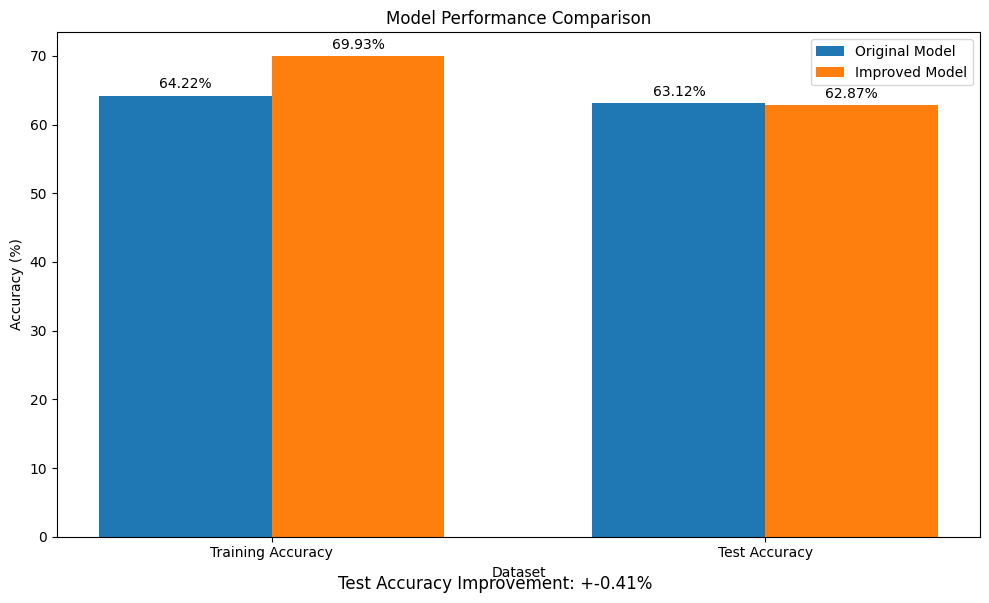

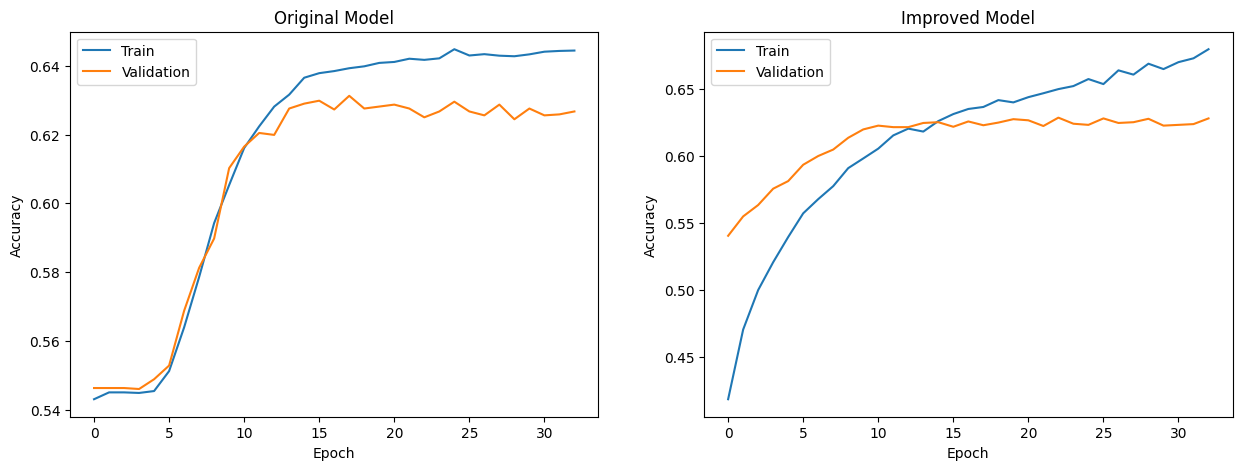

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda, Activation, Input, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import time
import matplotlib.pyplot as plt

# ================== Configuration ==================

AMINO_ACIDS = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
SPACER_IDX = 20  # 21st unit for spacer/padding
LABEL_MAP = {'h':0, 'e':1, '_':2}  # 3-class mapping as per paper

# ================== Data Loading & Preprocessing ==================

def parse_data(file_path):
    sequences = []
    current_seq = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#') or not line:
                continue
            if line in ('<>', '<end>'):
                if current_seq:
                    sequences.append(current_seq)
                current_seq = []
                continue
            parts = line.split()
            if len(parts) == 2 and parts[1].lower() in LABEL_MAP:
                current_seq.append((parts[0].upper(), parts[1].lower()))
    return sequences

def create_dataset(sequences):
    X, y = [], []
    for seq in sequences:
        seq_len = len(seq)
        for i in range(seq_len):
            # Create 13-residue window (i-6 to i+6)
            window = []
            for j in range(i-6, i+7):
                if j < 0 or j >= seq_len:
                    window.append(SPACER_IDX)
                else:
                    aa = seq[j][0]
                    window.append(AMINO_ACIDS.index(aa) if aa in AMINO_ACIDS else SPACER_IDX)

            # One-hot encode (13 positions × 21 units)
            encoded = np.zeros((13, 21), dtype=np.float32)
            for pos, idx in enumerate(window):
                encoded[pos, idx] = 1.0
            X.append(encoded.flatten())
            
            # Encode label
            label = LABEL_MAP[seq[i][1]]
            y.append(label)

    return np.array(X), tf.keras.utils.to_categorical(y, num_classes=3)

# ================== Model Architecture ==================

def create_original_model():
    """Recreate the original Qian & Sejnowski model for comparison"""
    model = Sequential([
        # Input: 273 units (13×21), Hidden: 40 units (paper specification)
        Dense(40, activation='sigmoid', input_dim=273),

        # Output with temperature scaling (T=1/2 as in paper)
        Dense(3, activation='linear'),
        Lambda(lambda x: x / 2),  # Temperature parameter
        Activation('softmax')
    ])

    # Original optimizer: SGD with lr=0.1, no momentum
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0),
        metrics=['accuracy']
    )
    return model

def create_improved_model():
    """
    Create an improved model with better regularization
    """
    inputs = Input(shape=(273,))
    
    # Hidden Layer 1 with L2 regularization and dropout
    x = Dense(64, kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Hidden Layer 2
    x = Dense(32, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    # Output layer without temperature scaling
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Use lower learning rate
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model

# ================== Evaluation Metrics ==================

def print_metrics(y_true, y_pred, name="Dataset"):
    labels = list(LABEL_MAP.keys())
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Q3 Accuracy
    acc = np.mean(y_true_labels == y_pred_labels)
    print(f"\n{name} Q3 Accuracy: {acc*100:.2f}%")

    # Matthews Correlation Coefficients
    print("\nMatthews CC:")
    for i, label in enumerate(labels):
        mcc = matthews_corrcoef(y_true_labels == i, y_pred_labels == i)
        print(f"C_{label}: {mcc:.3f}")

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_labels, y_pred_labels))
    
    return acc  # Return accuracy for model comparison

def plot_comparison(original_metrics, improved_metrics):
    """Plot a comparison of the original vs improved model"""
    labels = ['Training Accuracy', 'Test Accuracy']
    original_values = [original_metrics['train_acc'], original_metrics['test_acc']]
    improved_values = [improved_metrics['train_acc'], improved_metrics['test_acc']]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    original_bars = ax.bar(x - width/2, original_values, width, label='Original Model')
    improved_bars = ax.bar(x + width/2, improved_values, width, label='Improved Model')
    
    # Add labels and title
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    # Add exact values on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(original_bars)
    add_labels(improved_bars)
    
    # Add improvement percentage
    improvement = ((improved_metrics['test_acc'] - original_metrics['test_acc']) / 
                  original_metrics['test_acc'] * 100)
    plt.figtext(0.5, 0.01, f'Test Accuracy Improvement: +{improvement:.2f}%', 
                ha='center', fontsize=12)
    
    ax.legend()
    fig.tight_layout()
    
    plt.savefig('model_comparison.png')
    plt.show()
    
def plot_history(history1, history2):
    """Plot the training and validation accuracy history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original model
    ax1.plot(history1.history['accuracy'], label='Train')
    ax1.plot(history1.history['val_accuracy'], label='Validation')
    ax1.set_title('Original Model')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Improved model
    ax2.plot(history2.history['accuracy'], label='Train')
    ax2.plot(history2.history['val_accuracy'], label='Validation')
    ax2.set_title('Improved Model')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.savefig('training_history.png')
    plt.show()

# ================== Main Execution ==================

if __name__ == "__main__":
    # Load data
    train_data = parse_data("protein-secondary-structure.train.txt")
    test_data = parse_data("protein-secondary-structure.test.txt")

    # Create datasets
    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)

    # Verify input dimension matches paper (13×21=273)
    assert X_train.shape[1] == 273, "Invalid input dimension!"
    
    print("Dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # ---- TRAIN ORIGINAL MODEL ----
    print("\n\n===== ORIGINAL MODEL (Qian & Sejnowski 1988) =====")
    original_model = create_original_model()
    
    # Early stopping based on validation accuracy
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    start_time = time.time()
    # Train with paper's parameters (200 epochs, batch size 64)
    print("Training original model...")
    original_history = original_model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    original_train_time = time.time() - start_time
    
    # Final evaluation - original model
    print("\n===== Original Model Final Evaluation =====")
    train_pred = original_model.predict(X_train)
    test_pred = original_model.predict(X_test)
    
    original_metrics = {}
    original_metrics['train_acc'] = print_metrics(y_train, train_pred, "Training") * 100
    original_metrics['test_acc'] = print_metrics(y_test, test_pred, "Test") * 100
    
    # ---- TRAIN IMPROVED MODEL ----
    print("\n\n===== IMPROVED MODEL =====")
    improved_model = create_improved_model()
    
    # Enhanced callbacks
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    early_stop_improved = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train improved model
    start_time = time.time()
    print("Training improved model...")
    improved_history = improved_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=[early_stop_improved, checkpoint, reduce_lr],
        verbose=1
    )
    improved_train_time = time.time() - start_time
    
    # Final evaluation - improved model
    print("\n===== Improved Model Final Evaluation =====")
    improved_train_pred = improved_model.predict(X_train)
    improved_test_pred = improved_model.predict(X_test)
    
    improved_metrics = {}
    improved_metrics['train_acc'] = print_metrics(y_train, improved_train_pred, "Training") * 100
    improved_metrics['test_acc'] = print_metrics(y_test, improved_test_pred, "Test") * 100
    
    # Compare model training times
    print("\n===== Training Time Comparison =====")
    print(f"Original Model: {original_train_time:.2f} seconds")
    print(f"Improved Model: {improved_train_time:.2f} seconds")
    
    # Compare model performance with plots
    print("\n===== Performance Comparison =====")
    print(f"Original Model - Train Accuracy: {original_metrics['train_acc']:.2f}%, Test Accuracy: {original_metrics['test_acc']:.2f}%")
    print(f"Improved Model - Train Accuracy: {improved_metrics['train_acc']:.2f}%, Test Accuracy: {improved_metrics['test_acc']:.2f}%")
    
    improvement = ((improved_metrics['test_acc'] - original_metrics['test_acc']) / original_metrics['test_acc'] * 100)
    print(f"\nTest Accuracy Improvement: +{improvement:.2f}%")
    
    # Generate comparison plots
    plot_comparison(original_metrics, improved_metrics)
    plot_history(original_history, improved_history)